---
### **Value at Risk (VaR) - The Monte Carlo Method**
---

##### **What is Value at Risk (VaR)?**
Value at Risk (**VaR**) is a statistical measure used to estimate the potential loss in the value of a financial portfolio over a given time period at a specified confidence level. It answers the question:

> *"What is the maximum expected loss over a given time horizon with a certain probability?"*

The **Monte Carlo method** is a simulation-based approach for estimating VaR by generating multiple possible future portfolio outcomes based on stochastic processes.

##### **Mathematical Representation**
Given:
- **Portfolio value** at time $t$: $P_0$
- **Expected return per day**: $\mu$
- **Standard deviation of portfolio returns**: $\sigma$
- **Z-score** (randomly sampled from a standard normal distribution): $Z$
- **Time horizon** (number of days): $T$

Each simulated **portfolio return** over $T$ days is calculated as:

$$
\Delta P = P_0 \cdot \mu \cdot T + P_0 \cdot \sigma \cdot Z \cdot \sqrt{T}
$$

where:
- The **first term** represents the deterministic expected return.
- The **second term** represents the stochastic element due to volatility.

After **N** simulations, we obtain a distribution of possible portfolio returns. The **VaR** is then computed as the **$q^{th}$ percentile** of the simulated returns:

$$
VaR = -\text{Percentile}(\Delta P, (1 - \alpha) \times 100)
$$

where:
- $\alpha$ is the **confidence level** (e.g., 95% → 5th percentile).
- **VaR at 95% confidence** represents the **worst 5% loss scenario**.

##### **Interpretation**
- If **VaR(95%) = \$10,000**, it means there is a **95% probability that the portfolio will not lose more than $10,000$** over the given time horizon.
- Conversely, there is a **5% probability** that losses could **exceed** $10,000$.

##### **Advantages of the Monte Carlo Method**
1. **Flexibility:** Can be adapted to handle different return distributions if needed.
2. **Scenario-Based Analysis:** Can incorporate real-world events and dynamic portfolio behavior.
3. **Better Tail Risk Estimation:** Unlike analytical methods (e.g., variance-covariance), Monte Carlo captures extreme losses.

##### **Limitations**
- **Computationally Expensive:** Requires thousands (or millions) of simulations for accuracy.
- **Dependent on Distribution Assumptions:** The accuracy of the results depends on the assumption that **returns are normally distributed**. Specifically, we assume that:
  - **Portfolio log returns follow a normal distribution**:  
    $$
    r \sim \mathcal{N}(\mu, \sigma^2)
    $$
  - **Z-scores are drawn from a standard normal distribution**:  
    $$
    Z \sim \mathcal{N}(0,1)
    $$
  - **Portfolio returns over the time horizon follow**:  
    $$
    \Delta P
    $$
  
  If real-world returns deviate significantly from normality (e.g., fat tails, skewness), the Monte Carlo method may **underestimate extreme risks**.


Importing the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

Setting the **time range** for a certain amount of years.

In [2]:
years     = 15
endDate   = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)

Create a list of **ticker**.

In [3]:
# SPY := Largest S&P-500 ETF
# BND := Largest bond market ETF
# GLD := Largest commodity-based ETF that tracks the price of Gold
# QQQ := Largest Nasdaq ETF
# VTI := Vanguard's all-world stock index

tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

For each of these tickers, we download the daily adjusted **close prices**.

NB: We use *adjusted close prices* rather than *normal* ones because *adjusted close prices* account for dividends stock splits and our analysis will be *more accurate* by incorporating those.

In [4]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start=startDate, end=endDate)
    adj_close_df[ticker] = data['Adj Close']

adj_close_df.head(n=5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2010-02-12,82.010925,51.598274,107.040001,38.222767,41.808720
2010-02-16,83.301353,51.663383,109.620003,38.711903,42.510994
2010-02-17,83.696075,51.546185,109.250000,38.930271,42.747650
2010-02-18,84.189445,51.474560,109.980003,39.174850,42.991898
2010-02-19,84.364067,51.474560,109.470001,39.157383,43.144588


Calculate the **daily log returns** and drop any NAs.

The **simple return** (or percentage change) is calculated as:

$$
R_t = \frac{P_t}{P_{t-1}} - 1
$$

where:
- $R_t$ is the return for day \( t \),
- $P_t$ is the price at day \( t \),
- $P_{t-1}$ is the price at the previous day.

The **log return** is defined as:

$$
r_t = \ln \left(\frac{P_t}{P_{t-1}}\right)
$$

where $\ln$ represents the natural logarithm.

**Why Use Log Returns?** Logarithmic returns have an important property: **they are additive over time**.

For example, given two consecutive days' returns:

$$
r_t = \ln \left(\frac{P_t}{P_{t-1}}\right), \quad r_{t+1} = \ln \left(\frac{P_{t+1}}{P_t}\right)
$$

Adding these two:

$$
r_t + r_{t+1} = \ln \left(\frac{P_t}{P_{t-1}}\right) + \ln \left(\frac{P_{t+1}}{P_t}\right)
$$

Using the logarithmic property:

$$
\ln a + \ln b = \ln (a \cdot b)
$$

we get:

$$
r_t + r_{t+1} = \ln \left(\frac{P_{t+1}}{P_{t-1}}\right)
$$

This means that log returns can be **directly summed over multiple periods**, making them convenient for time-series analysis, portfolio aggregation, and statistical modeling. In contrast, simple returns are **not additive** but must be compounded, making calculations more complex when dealing with multiple periods.


In [5]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

log_returns.head(n=5)

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2010-02-16,0.015612,0.001261,0.023817,0.012716,0.016658
2010-02-17,0.004727,-0.002271,-0.003381,0.005625,0.005552
2010-02-18,0.005877,-0.001390,0.006660,0.006263,0.005697
2010-02-19,0.002072,0.000000,-0.004648,-0.000446,0.003545
2010-02-22,0.000180,-0.000380,-0.003661,-0.002010,-0.001594


Create a function that will be used to calculate **portfolio expected return**.

The expected return is computed as:

$$
\mathbb{E}[R] = \sum w_i \cdot \mu_i
$$

where $w_i$ is the weight of asset $i$ and $\mu_i$ is its mean log return.

*NB*: We are assuming that future returns are based on past returns, which is <u>not</u> a reliable assumption.

In [6]:
def expected_return(weights, log_returns):
    """
    Computes the expected return of a portfolio given asset weights and log returns.

    Parameters:
    ----------
    weights : numpy.ndarray
        A 1D array representing the allocation of weights for each asset in the portfolio.

    log_returns : pandas.DataFrame
        A DataFrame where each column represents an asset, and each row represents a time period.
        The values are the log returns of each asset.

    Returns:
    -------
    float
        The expected return of the portfolio, computed as the weighted average of the mean log returns.
    """
    return np.sum(log_returns.mean() * weights)

Create a covariance matrix for all the securities.

The **covariance matrix** is a **square matrix** that contains the covariances between different assets in a portfolio. It helps measure how asset returns move together.

For a portfolio with **n** assets, the covariance matrix $\Sigma$ is an $n \times n$ matrix where the element at position $(i, j)$ represents the covariance between the returns of asset $i$ and asset $j$:

$$
\Sigma = 
\begin{bmatrix}
\sigma_{1,1} & \sigma_{1,2} & \dots & \sigma_{1,n} \\
\sigma_{2,1} & \sigma_{2,2} & \dots & \sigma_{2,n} \\
\vdots & \vdots & \ddots & \vdots \\
\sigma_{n,1} & \sigma_{n,2} & \dots & \sigma_{n,n}
\end{bmatrix}
$$

where $\sigma_{i,j}$ is the covariance between asset $i$ and asset $j$, given by:

$$
\sigma_{i,j} = \text{Cov}(R_i, R_j) = \mathbb{E}[(R_i - \mu_i)(R_j - \mu_j)]
$$

- If $i = j$, then $\sigma_{i,j}$ represents the **variance** of asset $i$ $(\sigma^2_i)$.
- If $i \neq j$, then $\sigma_{i,j}$ represents the **covariance** between assets $i$ and $j$.

In [7]:
cov_matrix = log_returns.cov()
cov_matrix

,SPY,BND,GLD,QQQ,VTI
SPY,1.156387e-04,2.427886e-07,0.000005,0.000129,1.180729e-04
BND,2.427886e-07,9.380608e-06,0.000009,0.000001,4.463537e-07
GLD,4.990221e-06,9.108827e-06,0.000095,0.000006,5.554348e-06
QQQ,1.287985e-04,1.117414e-06,0.000006,0.000166,1.315384e-04
VTI,1.180729e-04,4.463537e-07,0.000006,0.000132,1.215346e-04


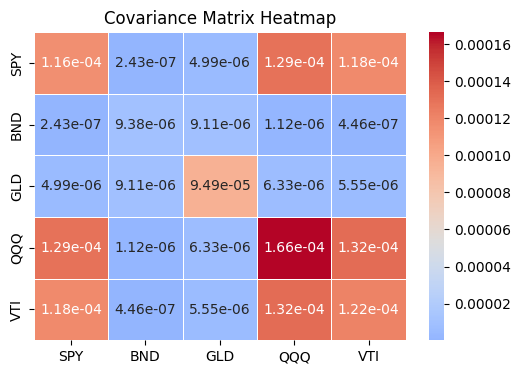

In [8]:
# Bonus: plotting the covariance matrix
import seaborn as sns

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cov_matrix, annot=True, fmt=".2e", cmap="coolwarm", center=cov_matrix.values.mean(), linewidths=0.5)

plt.title("Covariance Matrix Heatmap")
plt.show()

Create a function that will be used to calculate **portfolio standard deviation**.

The standard deviation (volatility) of the portfolio can be computed as:

$$
\sigma_p = \sqrt{w^T \Sigma w}
$$

where $w$ is the weight vector and $\Sigma$ is the covariance matrix.

In [9]:
def standard_deviation(weights, cov_matrix):
    """
    Computes the standard deviation (volatility) of a portfolio given asset weights and 
    the covariance matrix of asset returns.

    Parameters:
    ----------
    weights : numpy.ndarray
        A 1D array representing the allocation of weights for each asset in the portfolio.

    cov_matrix : numpy.ndarray
        A 2D square matrix representing the covariance matrix of asset returns.
        The (i, j) entry represents the covariance between asset i and asset j.

    Returns:
    -------
    float
        The standard deviation (volatility) of the portfolio, computed as:
    """
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

Create a function that gives a random **Z-score** based on normal distribution. This is going to be very useful to run 10'000 simulations.

The output will represent a sample from:
$$
\mathcal{N}(0,1),
$$
commonly used in statistics for hypothesis testing and probability calculations.

In [10]:
def random_z_score():
    """
    Generates a random Z-score from a standard normal distribution.

    Returns:
    -------
    float
        A randomly sampled value from a standard normal distribution (mean = 0, std = 1).
    """
    return np.random.normal(0, 1)

Create a function to calculate **scenarioGainLoss**. The function estimates the **potential gain or loss** of a portfolio over a given time horizon based on **expected returns** and **volatility**.

The formula used is:

$$
\Delta P = P_0 \cdot \mu \cdot T + P_0 \cdot \sigma \cdot Z \cdot \sqrt{T}
$$

where:
- $P_0$ = initial portfolio value
- $\mu$ = expected return per day
- $T$ = number of days (time horizon)
- $\sigma$ = standard deviation (volatility) of portfolio returns
- $Z$ = Z-score (number of standard deviations from the mean)

**Interpretation:**
1. **Expected Return Component:**
   $$
   P_0 \cdot \mu \cdot T
   $$
   - This represents the deterministic growth of the portfolio based on the expected return over time.

2. **Volatility Component:**
   $$
   P_0 \cdot \sigma \cdot Z \cdot \sqrt{T}
   $$
   - This captures the uncertainty due to market fluctuations, scaled by the Z-score to reflect potential upside/downside movements.

This formula helps **simulate potential outcomes** for portfolio value under different risk scenarios.


In [11]:
def scenario_gain_loss(portfolio_value, portfolio_expected_return, portfolio_std_dev, z_score, days):
    """
    Estimates the potential gain or loss of a portfolio over a given time horizon using 
    expected returns and volatility.

    Parameters:
    ----------
    portfolio_value : float
        The current value of the portfolio.

    portfolio_expected_return : float
        The expected daily return of the portfolio.

    portfolio_std_dev : float
        The standard deviation (volatility) of the portfolio returns.

    z_score : float
        The Z-score representing the number of standard deviations away from the mean 
        in a normal distribution.

    days : int
        The time horizon (number of days) over which the scenario is projected.

    Returns:
    -------
    float
        The projected portfolio value change over the given period, incorporating both 
        expected returns and volatility.
    """
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

Create an **equally weighted portfolio** and find total portfolio **expected return and standard deviation**.

In [12]:
# Assume a portfolio value of $1M, equally weighted.
portfolio_value = 1000000
weights         = np.array([1 / len(tickers)] * len(tickers))

# Calculate portfolio expected returns and standard deviation
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev         = standard_deviation(weights, cov_matrix)

Run 10'000 simulations.

In [13]:
days = 5
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_expected_return, portfolio_std_dev, z_score, days))

Specify a **Confidence Interval** and **calculate VaR**.

The **VaR is computed** as:

$$
VaR = -\text{Percentile}( \text{scenarioReturn}, 100 \times (1 - \text{confidence interval}) )
$$

where:
- `scenarioReturn` contains simulated portfolio returns over `days` using **Monte Carlo simulation**.
- `confidence_interval = 0.95` means we are computing **5% worst-case losses**.
- `np.percentile()` finds the **5th percentile** of simulated returns.

**Monte Carlo Simulation Process**

1. **Set Parameters:**
   - `days = 5`: The risk horizon is 5 days.
   - `simulations = 10,000`: We run 10,000 simulations for portfolio returns.
   - `confidence_interval = 0.95`: We calculate the **5% worst-case loss**.

2. **Generate Scenarios:**
   - For each simulation, a **random Z-score** is drawn from a standard normal distribution.
   - This Z-score is used in `scenario_gain_loss()` to estimate a possible portfolio return over `days`.
   - The result is stored in `scenarioReturn`.

3. **Compute Value at Risk (VaR):**
   - We take the **5th percentile** of the simulated returns, which represents the maximum loss at the **95% confidence level**.

In [14]:
confidence_interval = 0.95
VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))

print(VaR)

# NB: VaR is obviously increasing with the confidence_interval level and the number of days considered
print(-np.percentile(scenarioReturn, 100 * (1 - 0.99)))

24960.491911718047
36351.19115103925


Plot **results**.

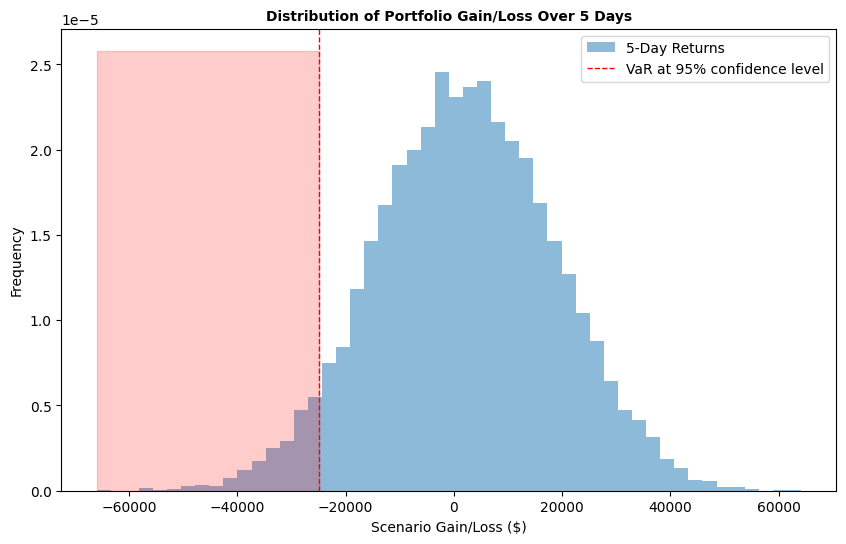

In [15]:
plt.figure(figsize=(10, 6))

# Plot the histogram
plt.hist(scenarioReturn, bins=50, density=True, alpha = 0.5, label=f'{days}-Day Returns')

# Formatting labels and title
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days', fontsize=10, fontweight='bold')

# Add Value at Risk (VaR) line
plt.axvline(-VaR, color='red', linestyle='dashed', linewidth=1, label=f'VaR at {confidence_interval:.0%} confidence level')

# Shade the area under the VaR threshold
plt.fill_betweenx(y=np.linspace(0, plt.ylim()[1], 100), x1=-VaR, x2=min(scenarioReturn), color='red', alpha=0.2)

plt.legend()
plt.show()

The histogram represents the **simulated distribution of portfolio returns over 5 days** using a Monte Carlo approach. The blue bars show the **frequency of different gain/loss scenarios**, with most returns centered around the mean, forming a normal-like shape. The **red dashed line** marks the **Value at Risk (VaR) at 95% confidence**, indicating the **5% worst expected loss**. The **shaded red area** highlights these extreme loss scenarios, meaning there is a **5% probability of losing more than this amount**. This visualization helps assess downside risk, showing both typical portfolio behavior and worst-case losses.